# Diamonds evaluation

## Laden und Vorbereiten der Daten

In [85]:
import pandas as pd
import os

diamonds = pd.read_csv("diamonds.csv")

In [86]:
diamonds["size"] = diamonds["x"] * diamonds["y"] * diamonds["z"]
X = diamonds[["carat", "cut", "color", "clarity", "depth", "table", "size"]]
y = diamonds[["price"]]

In [87]:
from sklearn.preprocessing import OrdinalEncoder

X.loc[:, ["cut"]] = OrdinalEncoder().fit_transform(X[["cut"]])
X.loc[:, ["color"]] = OrdinalEncoder().fit_transform(X[["color"]])
X.loc[:, ["clarity"]] = OrdinalEncoder().fit_transform(X[["clarity"]])

In [88]:
columns_to_scale = ["carat", "depth", "table", "size"]

for column in columns_to_scale:
    column_min = X[column].min()
    column_max = X[column].max()
    X.loc[:, [column]] = (X[column] - column_min) / (column_max - column_min)

X.head(100)

,carat,cut,color,clarity,depth,table,size
0,0.006237,2.0,1.0,3.0,0.513889,0.230769,0.009947
1,0.002079,3.0,1.0,2.0,0.466667,0.346154,0.008985
2,0.006237,1.0,1.0,4.0,0.386111,0.423077,0.009914
3,0.018711,3.0,5.0,5.0,0.538889,0.288462,0.012166
4,0.022869,1.0,6.0,3.0,0.563889,0.288462,0.013518
...,...,...,...,...,...,...,...
95,0.103950,1.0,1.0,5.0,0.402778,0.288462,0.030376
96,0.103950,1.0,2.0,4.0,0.455556,0.365385,0.029116
97,0.158004,0.0,2.0,3.0,0.647222,0.365385,0.039535
98,0.110187,4.0,1.0,2.0,0.516667,0.307692,0.030914


In [89]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size= 0.2, random_state = 36
)

len(X_train), len(X_test)

(43152, 10788)

## Laden des Models

In [90]:
import joblib

diamonds_model = joblib.load('diamonds_price_algorithm.joblib')
diamonds_model

KNeighborsRegressor(n_neighbors=4)

## Besonders aussagekräftige Felder

Text(0, 0.5, 'Durchschnittliche Verringerung der Unreinheit')

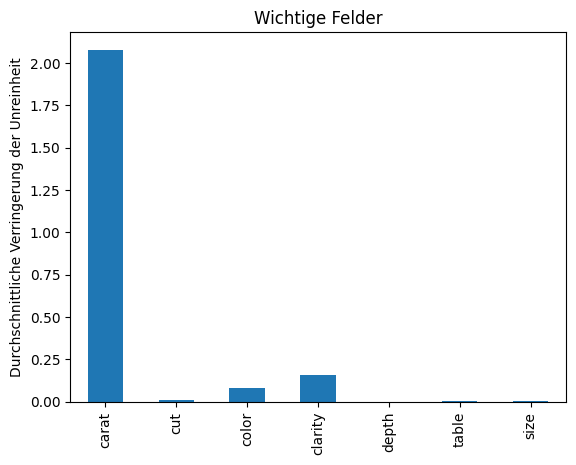

In [91]:
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
 
result = permutation_importance(
    diamonds_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
 
forest_importances = pd.Series(result.importances_mean, index=X_train.columns)
 
fig, ax = plt.subplots()
forest_importances.plot.bar()
ax.set_title("Wichtige Felder")
ax.set_ylabel("Durchschnittliche Verringerung der Unreinheit")

Das Feld "carat" ist am wichtigsten und am aussagekräftigsten. Die restlichen Felder sind nahezu unnötig. Sie helfen aber bei den feinen Abstufungen des Preises.

## Messmetrik bestimmen und berechnen

Ich berechne den MSE, weil ich ein Regressionsmodel habe.

In [92]:
from sklearn.metrics import mean_squared_error

print("MSE:", mean_squared_error(y_test, predictions))

MSE: 657546.1618464962


## Wahrheitsmetrik

**Bedingung:** Kostet der Diamant mehr als 10'000?

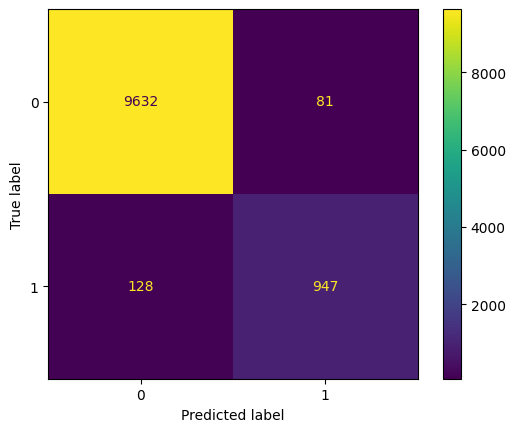

In [93]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred = diamonds_model.predict(X_test)

# Schwelle festlegen: Preis > 10'000 = "teuer"
y_test_class = (y_test > 10000).astype(int)
y_pred_class = (y_pred > 10000).astype(int)

cm = confusion_matrix(y_test_class, y_pred_class)
display = ConfusionMatrixDisplay(confusion_matrix=cm)
display.plot()

### Recall und Precision

In [94]:
from sklearn.metrics import classification_report
print(classification_report(y_test_class, y_pred_class, target_names=["Billig", "Teuer"]))

              precision    recall  f1-score   support

      Billig       0.99      0.99      0.99      9713
       Teuer       0.92      0.88      0.90      1075

    accuracy                           0.98     10788
   macro avg       0.95      0.94      0.94     10788
weighted avg       0.98      0.98      0.98     10788



## Wie gut funktioniert mein Modell?

Das Modell funktioniert sehr gut. Es ist sehr stark abhängig vom Karatwert. Dies bedeutet, dass dieser sehr genau angegeben werden soll. Der berechnete MSE beträgt 657'546.16 und ist somit sehr hoch. Das Modell erreicht eine "precision" von 99%, einen "recall" von 99% und einen f1-Score von 99%. Diese Werte sind wiederrum exzellent.